In [14]:
# Import Libraries
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
from nltk.corpus import stopwords
from flask import Flask, request, jsonify
import streamlit as st
# Download NLTK stopwords
import nltk
nltk.download('stopwords')

import joblib

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oouje\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# Step 1: Preprocessing the Data
# 1.1 Load datasets, combine them, and shuffle.
real_df = pd.read_csv('True.csv')
fake_df = pd.read_csv('Fake.csv')

# Check for null values
assert not real_df.isnull().values.any(), "True.csv contains null values."
assert not fake_df.isnull().values.any(), "Fake.csv contains null values."


In [16]:
# 1.2 Add labels: 0 for real news, 1 for fake news.
real_df['label'] = 0
fake_df['label'] = 1

In [17]:
# 1.3 Combine the datasets and shuffle.
df = pd.concat([real_df, fake_df], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [18]:
# 1.4 Display dataset information and class distribution.
print("Dataset Information:")
print(df.info())
print("Class Distribution:\n", df['label'].value_counts())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB
None
Class Distribution:
 label
1    23481
0    21417
Name: count, dtype: int64


In [19]:
# 1.5 Text cleaning: lowercase, remove punctuation, numbers, and stopwords.
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = " ".join(word for word in text.split() if word not in stop_words)
    return text

# Apply text cleaning.
df['text'] = df['text'].apply(clean_text)

In [20]:
# 1.6 Split data into training and testing sets.
X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Feature Engineering

In [21]:
# 2.1 Extract common features using TF-IDF.
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Save the TF-IDF vectorizer for future use
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

# Save extracted features to CSV
feature_names = tfidf.get_feature_names_out()
train_features_df = pd.DataFrame(X_train_tfidf.toarray(), columns=feature_names)
test_features_df = pd.DataFrame(X_test_tfidf.toarray(), columns=feature_names)

train_features_df.to_csv("Train_Features.csv", index=False)
test_features_df.to_csv("Test_Features.csv", index=False)

# Train and save models
# Train Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train_tfidf, y_train)
joblib.dump(log_reg, 'logistic_model.pkl')  # Save the model

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tfidf, y_train)
joblib.dump(rf, 'random_forest_model.pkl')  # Save the model

# Load models if needed
logistic_model = joblib.load('logistic_model.pkl')
random_forest_model = joblib.load('random_forest_model.pkl')

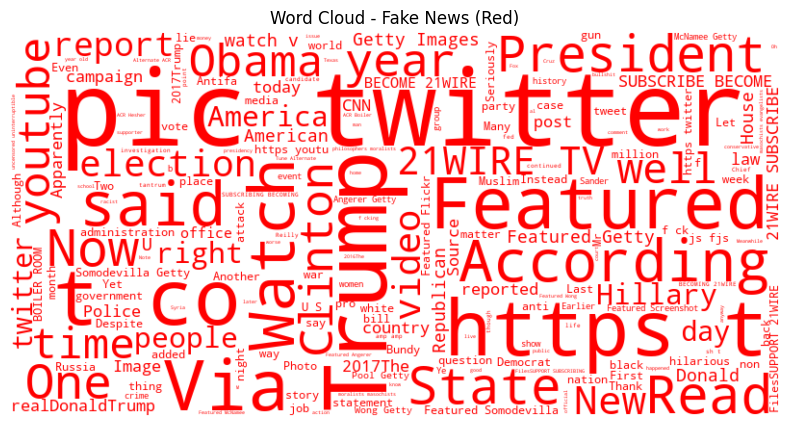

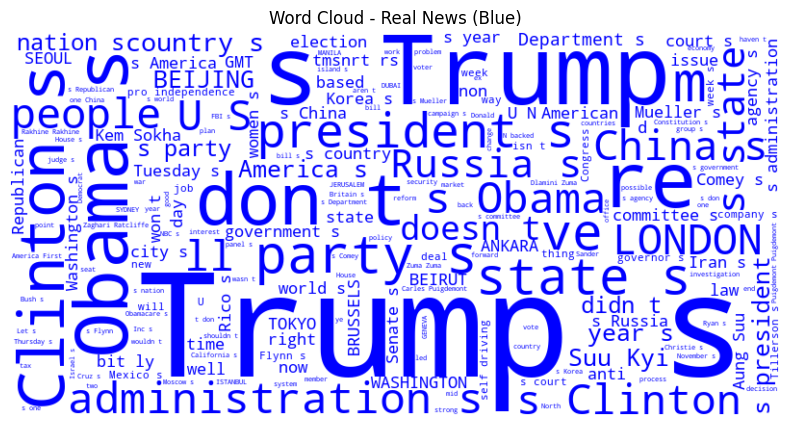

In [22]:
# 2.2 Create visualizations
# Extract words specific to fake and real news
fake_words = " ".join(fake_df['text']).split()
real_words = " ".join(real_df['text']).split()

# Count word frequencies for fake and real news
fake_word_counts = Counter(fake_words)
real_word_counts = Counter(real_words)

# Identify distinctive words for fake and real news
fake_specific_words = {word for word in fake_word_counts if word not in real_word_counts}
real_specific_words = {word for word in real_word_counts if word not in fake_word_counts}

# Create a function to color the words
def red_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "rgb(255, 0, 0)"  # Red color for fake news

def blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "rgb(0, 0, 255)"  # Blue color for real news

# Generate Fake News Word Cloud
fake_text = " ".join([word for word in fake_words if word in fake_specific_words])
fake_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(fake_text)

plt.figure(figsize=(10, 5))
plt.imshow(fake_wordcloud.recolor(color_func=red_color_func), interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Fake News (Red)")
plt.show()

# Generate Real News Word Cloud
real_text = " ".join([word for word in real_words if word in real_specific_words])
real_wordcloud = WordCloud(width=800, height=400, background_color="white").generate(real_text)

plt.figure(figsize=(10, 5))
plt.imshow(real_wordcloud.recolor(color_func=blue_color_func), interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Real News (Blue)")
plt.show()

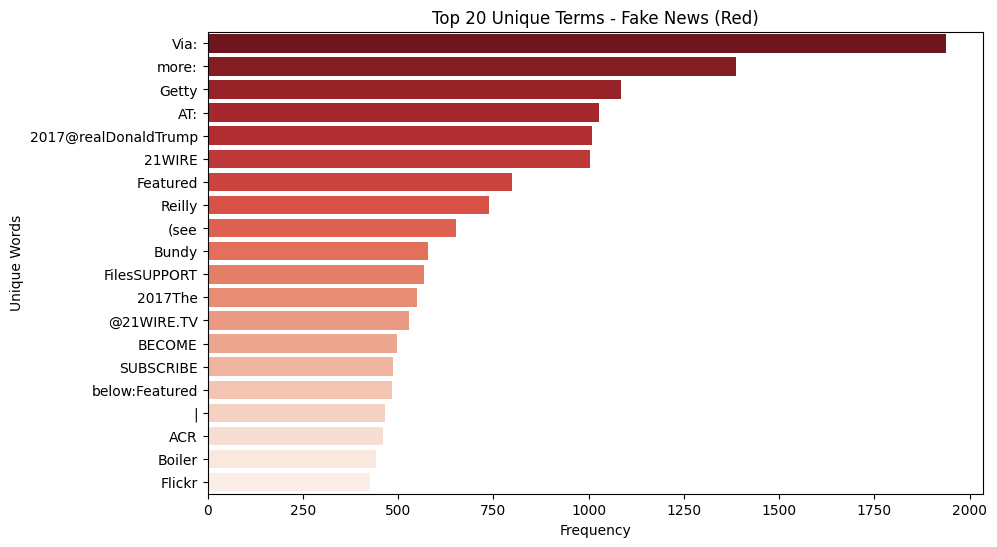

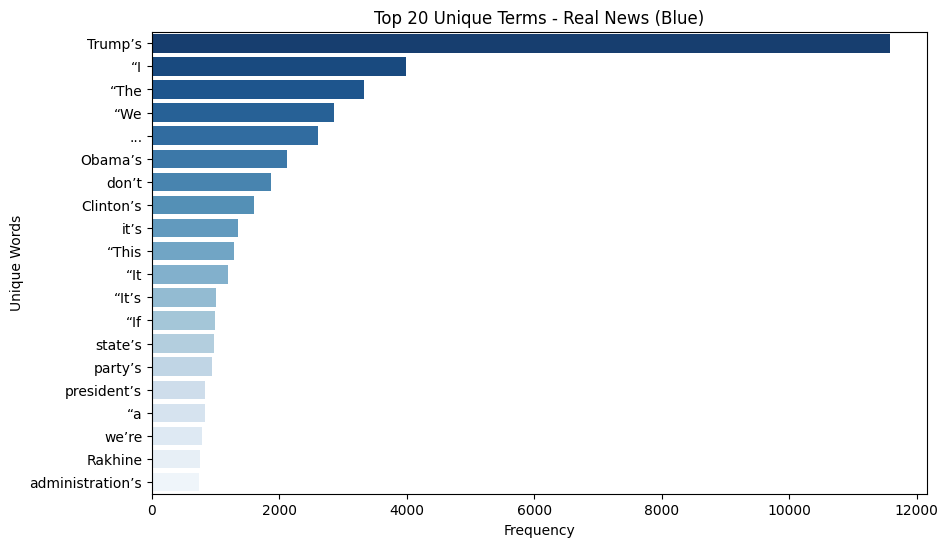

In [23]:
# Bar chart for top terms
# Calculate unique word frequencies
fake_unique_words = [word for word in fake_words if word in fake_specific_words]
real_unique_words = [word for word in real_words if word in real_specific_words]

fake_unique_counts = Counter(fake_unique_words).most_common(20)
real_unique_counts = Counter(real_unique_words).most_common(20)

# Convert to DataFrames for easier plotting
fake_unique_df = pd.DataFrame(fake_unique_counts, columns=["Word", "Frequency"])
real_unique_df = pd.DataFrame(real_unique_counts, columns=["Word", "Frequency"])

# Corrected bar charts to fix the FutureWarning
# Fake News (Red)
plt.figure(figsize=(10, 6))
sns.barplot(data=fake_unique_df, x="Frequency", y="Word", hue="Word", dodge=False, palette="Reds_r", legend=False)
plt.title("Top 20 Unique Terms - Fake News (Red)")
plt.xlabel("Frequency")
plt.ylabel("Unique Words")
plt.show()

# Real News (Blue)
plt.figure(figsize=(10, 6))
sns.barplot(data=real_unique_df, x="Frequency", y="Word", hue="Word", dodge=False, palette="Blues_r", legend=False)
plt.title("Top 20 Unique Terms - Real News (Blue)")
plt.xlabel("Frequency")
plt.ylabel("Unique Words")
plt.show()





C:\Users\oouje\AppData\Local\Temp\ipykernel_26440\3256602450.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['label'], y=df['text_length'], palette="coolwarm", dodge=False)


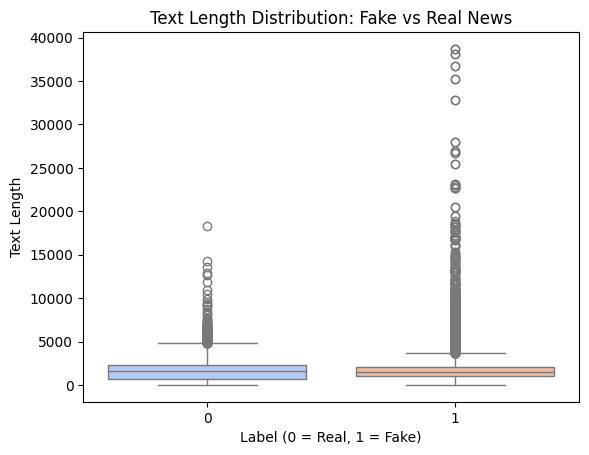

In [24]:
# Compare text lengths for Fake and Real News
df['text_length'] = df['text'].apply(len)
fake_lengths = df[df['label'] == 1]['text_length']
real_lengths = df[df['label'] == 0]['text_length']

# Boxplot for text lengths
sns.boxplot(x=df['label'], y=df['text_length'], palette="coolwarm", dodge=False)
plt.title("Text Length Distribution: Fake vs Real News")
plt.xlabel("Label (0 = Real, 1 = Fake)")
plt.ylabel("Text Length")
plt.show()


# Step 3: Model Training and Evaluation

In [25]:
# Evaluation function
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    print(f"Evaluation Metrics for {model_name}:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\n")

# Evaluate the pre-trained models
evaluate_model(logistic_model, X_test_tfidf, y_test, "Logistic Regression (Pre-Trained)")
evaluate_model(random_forest_model, X_test_tfidf, y_test, "Random Forest (Pre-Trained)")

Evaluation Metrics for Logistic Regression (Pre-Trained):
Accuracy: 0.9884187082405346
Precision: 0.9918121094591683
Recall: 0.985864210751767
F1 Score: 0.9888292158968851
ROC-AUC: 0.9885247752900566
Confusion Matrix:
 [[4273   38]
 [  66 4603]]


Evaluation Metrics for Random Forest (Pre-Trained):
Accuracy: 0.9975501113585746
Precision: 0.9991407089151451
Recall: 0.9961447847504818
F1 Score: 0.9976404976404977
ROC-AUC: 0.9976084628925224
Confusion Matrix:
 [[4307    4]
 [  18 4651]]




# Step 4: Hyperparameter Tuning

In [26]:
param_grid = {'C': [0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train_tfidf, y_train)

best_log_reg = grid_search.best_estimator_
print("Best Parameters for Logistic Regression:", grid_search.best_params_)
evaluate_model(best_log_reg, X_test_tfidf, y_test, "Tuned Logistic Regression")

Best Parameters for Logistic Regression: {'C': 10}
Evaluation Metrics for Tuned Logistic Regression:
Accuracy: 0.9937639198218263
Precision: 0.99612819961282
Recall: 0.9918612122510173
F1 Score: 0.9939901266366173
ROC-AUC: 0.9938429234532749
Confusion Matrix:
 [[4293   18]
 [  38 4631]]


